# 23. Convolutional AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 23.1 Preparing MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=1,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

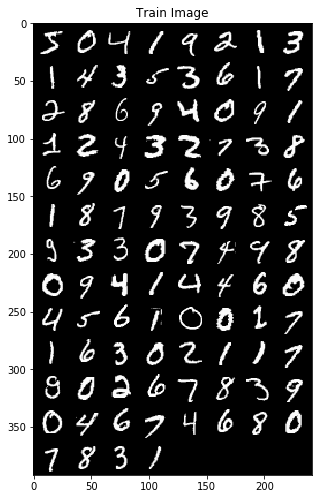

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 23.2 Define Model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        
        return out

In [9]:
E = Encoder().cuda()
D = Decoder().cuda()

## 22.3 Model Training

In [10]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [11]:
num_epochs = 5

In [12]:
for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        pre = D(E(X))
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/5], lter [100/600], Loss: 0.0557
Epoch [1/5], lter [200/600], Loss: 0.0303
Epoch [1/5], lter [300/600], Loss: 0.0212
Epoch [1/5], lter [400/600], Loss: 0.0173
Epoch [1/5], lter [500/600], Loss: 0.0166
Epoch [1/5], lter [600/600], Loss: 0.0217
Epoch [2/5], lter [100/600], Loss: 0.0123
Epoch [2/5], lter [200/600], Loss: 0.0141
Epoch [2/5], lter [300/600], Loss: 0.0126
Epoch [2/5], lter [400/600], Loss: 0.0112
Epoch [2/5], lter [500/600], Loss: 0.0102
Epoch [2/5], lter [600/600], Loss: 0.0147
Epoch [3/5], lter [100/600], Loss: 0.0083
Epoch [3/5], lter [200/600], Loss: 0.0099
Epoch [3/5], lter [300/600], Loss: 0.0095
Epoch [3/5], lter [400/600], Loss: 0.0082
Epoch [3/5], lter [500/600], Loss: 0.0088
Epoch [3/5], lter [600/600], Loss: 0.0122
Epoch [4/5], lter [100/600], Loss: 0.0071
Epoch [4/5], lter [200/600], Loss: 0.0086
Epoch [4/5], lter [300/600], Loss: 0.0085
Epoch [4/5], lter [400/600], Loss: 0.0073
Epoch [4/5], lter [500/600], Loss: 0.0077
Epoch [4/5], lter [600/600], Loss:

## 22.4 Test Model

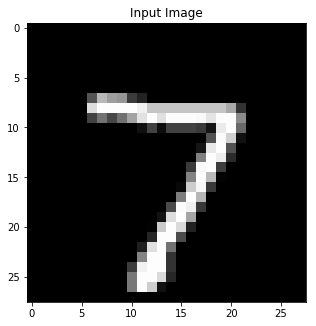

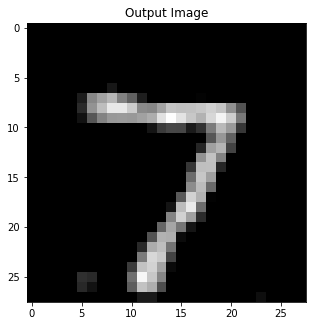

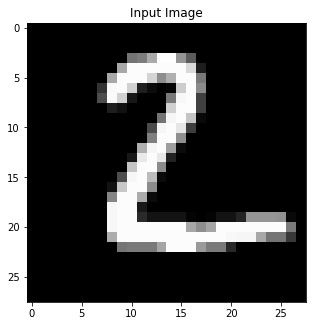

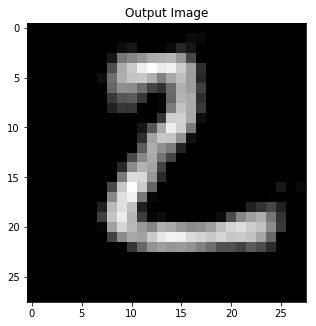

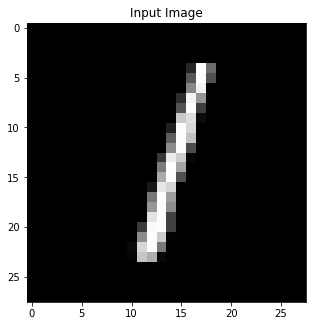

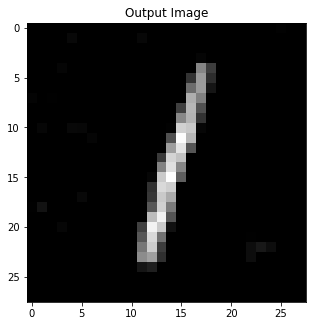

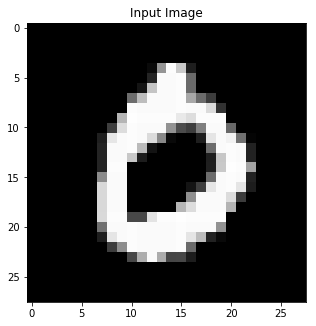

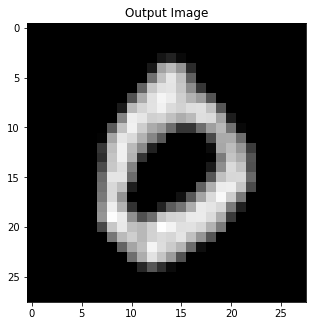

In [13]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    imshow(torchvision.utils.make_grid(images, normalize=True), "Input Image")
    
    images = images.cuda()
    outputs = D(E(images))
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break

## 22.5 Make Random Image

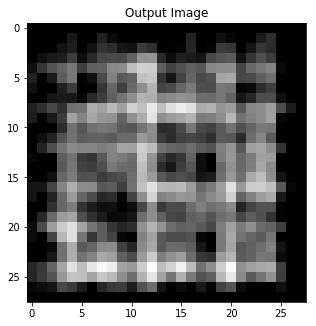

In [14]:
z = torch.rand(E(images).size()).cuda()
outputs = D(z)
imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")